In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [157]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [163]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=((96, 96, 3)))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")



In [164]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=((96,96, 3)))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_120 (InputLayer)      [(None, 96, 96, 3)]       0         
                                                                 
 encoder (Functional)        (None, 12, 12, 16)        95312     
                                                                 
 vector_quantizer (VectorQua  (None, 12, 12, 16)       1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 96, 96, 3)         111683    
                                                                 
Total params: 208,019
Trainable params: 208,019
Non-trainable params: 0
_________________________________________________________________


In [165]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [166]:
train_path = pd.read_csv("../01_Data_Preparation/subsampled_train_df.csv")

In [167]:
val_path = pd.read_csv("../01_Data_Preparation/subsampled_val_df.csv")

In [168]:
train_path.head()

,filename,label
0,./MMAFEDB/train/happy/Happy.16914.jpg,happy
1,./MMAFEDB/train/happy/71032Exp3awe_student_567...,happy
2,./MMAFEDB/train/happy/76386Exp3amazed_teacher_...,happy
3,./MMAFEDB/train/happy/60310Exp3amazed_wife_713...,happy
4,./MMAFEDB/train/happy/60056Exp3amazed_wife_328...,happy


In [142]:
x_train = []
for each in train_path['filename']:
  img = Image.open(each)
  if img is not None:
    img = img.convert('RGB')  # convert image to RGB
    img = img.resize((96,96)) # Resize images to 48x48
    img = np.array(img)
    x_train.append(img)
  else:
    print(f'Could not open image: {each}')
x_train = np.array(x_train)
x_train = x_train.astype('float32') / 255.0 # normalize pixel values
x_train -= 0.5 # standardize around 0

In [169]:
x_val = []
for each in val_path['filename']:
  img = Image.open(each)
  if img is not None:
    img = img.convert('RGB')  # convert image to RGB
    img = img.resize((96,96)) # Resize images to 48x48
    img = np.array(img)
    x_val.append(img)
  else:
    print(f'Could not open image: {each}')
x_val = np.array(x_val)
x_val = x_val.astype('float32') / 255.0 # normalize pixel values
x_val -= 0.5 # standardize around 0

In [170]:
data_variance = np.var(x_train)

In [145]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50
165/165 [==============================] - 18s 101ms/step - loss: 12.2147 - reconstruction_loss: 1.3967 - vqvae_loss: 9.9044
Epoch 2/50
165/165 [==============================] - 16s 98ms/step - loss: 0.9378 - reconstruction_loss: 0.6837 - vqvae_loss: 0.2406
Epoch 3/50
165/165 [==============================] - 16s 97ms/step - loss: 0.6948 - reconstruction_loss: 0.6312 - vqvae_loss: 0.0590
Epoch 4/50
165/165 [==============================] - 16s 97ms/step - loss: 0.6391 - reconstruction_loss: 0.6091 - vqvae_loss: 0.0343
Epoch 5/50
165/165 [==============================] - 16s 97ms/step - loss: 0.6096 - reconstruction_loss: 0.5978 - vqvae_loss: 0.0123
Epoch 6/50
165/165 [==============================] - 16s 96ms/step - loss: 0.6034 - reconstruction_loss: 0.5936 - vqvae_loss: 0.0096
Epoch 7/50
165/165 [==============================] - 16s 97ms/step - loss: 0.5994 - reconstruction_loss: 0.5915 - vqvae_loss: 0.0094
Epoch 8/50
165/165 [==============================] - 16s 97

1/1 [==============================] - 0s 283ms/step


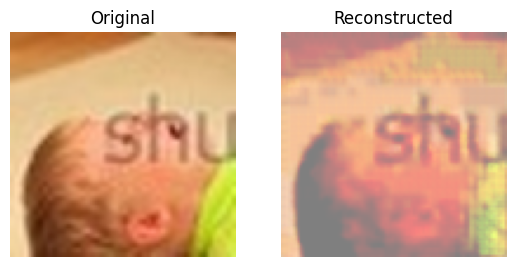

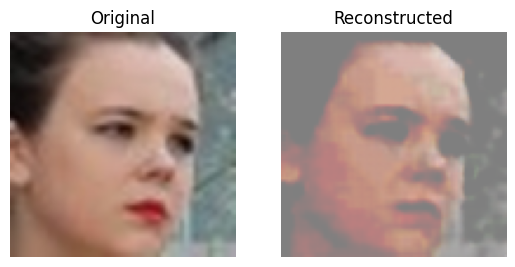

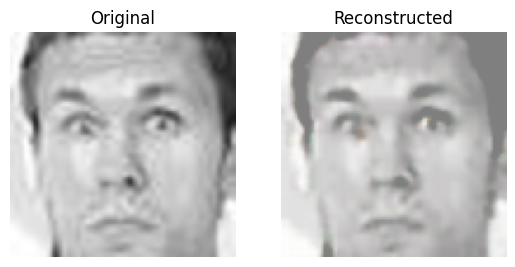

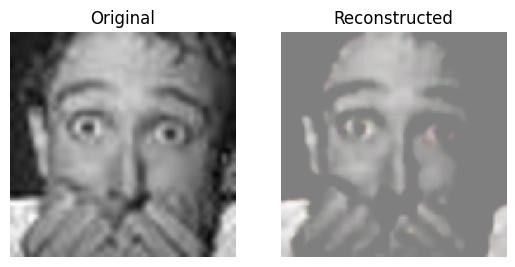

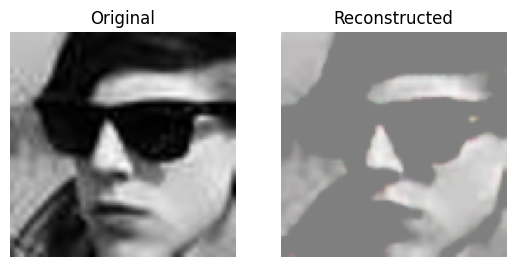

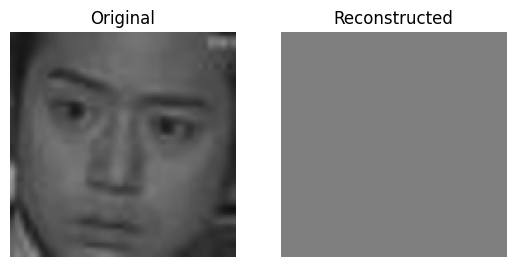

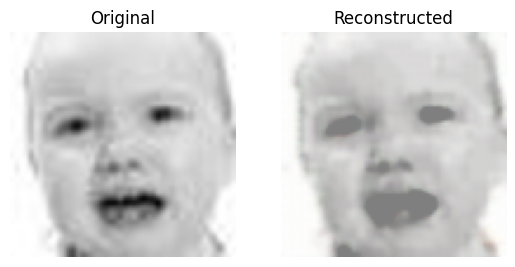

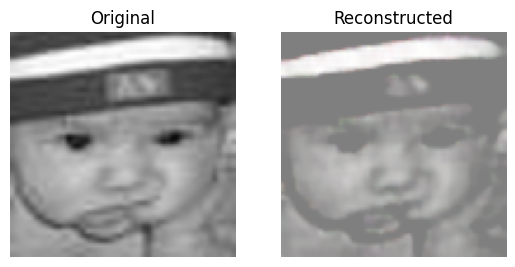

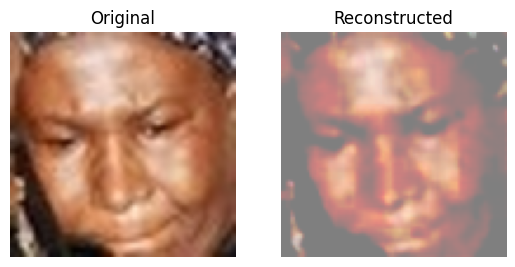

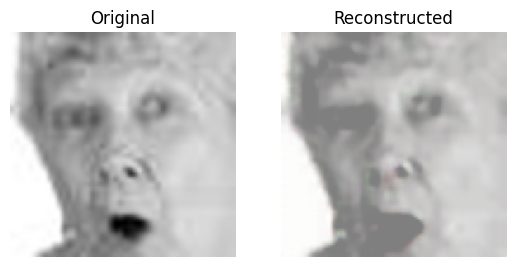

In [146]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_train), 10)
train_images = x_train[idx]
reconstructions_test = trained_vqvae_model.predict(train_images)

for train_image, reconstructed_image in zip(train_images, reconstructions_test):
    show_subplot(train_image, reconstructed_image)

In [149]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(train_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

1/1 [==============================] - 0s 15ms/step


In [150]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (24, 24)


In [151]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_106 (InputLayer)      [(None, 24, 24)]          0         
                                                                 
 tf.one_hot_4 (TFOpLambda)   (None, 24, 24, 128)       0         
                                                                 
 pixel_conv_layer_20 (PixelC  (None, 24, 24, 128)      802944    
 onvLayer)                                                       
                                                                 
 residual_block_8 (ResidualB  (None, 24, 24, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_9 (ResidualB  (None, 24, 24, 128)      98624     
 lock)                                                           
                                                         

In [152]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

657/657 [==============================] - 3s 5ms/step
Shape of the training data for PixelCNN: (21000, 24, 24)


In [153]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
148/148 [==============================] - 25s 159ms/step - loss: 0.5950 - accuracy: 0.9867 - val_loss: 3.5556e-04 - val_accuracy: 1.0000
Epoch 2/10
 49/148 [========>.....................] - ETA: 14s - loss: 1.3418e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [154]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [155]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 23ms/step
Prior shape: (10, 24, 24)


1/1 [==============================] - 0s 64ms/step


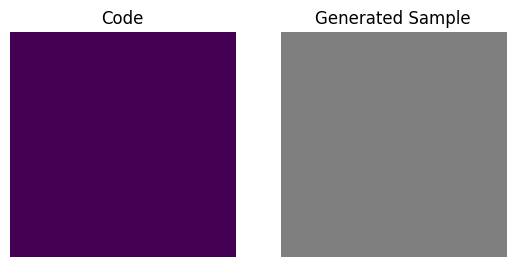

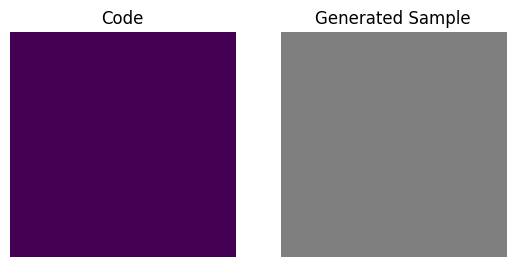

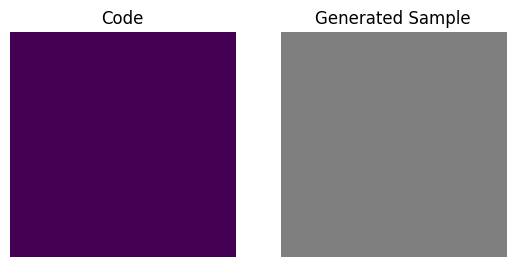

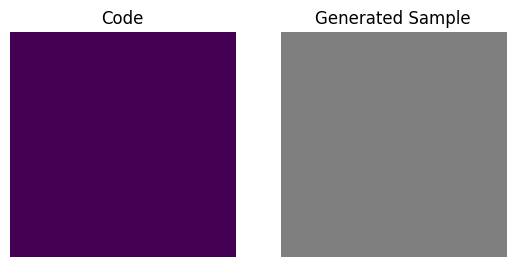

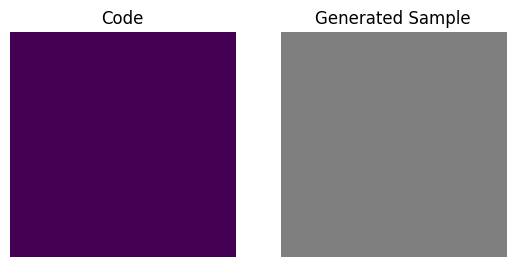

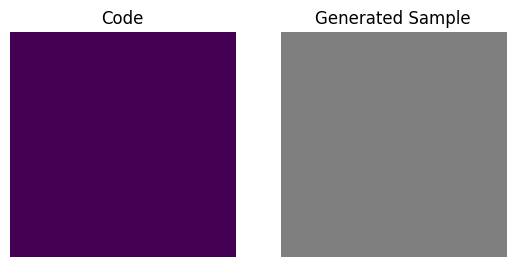

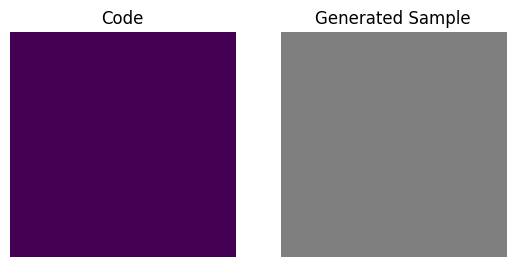

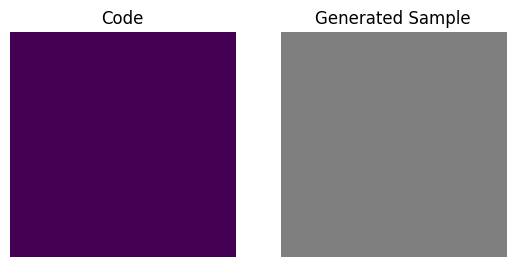

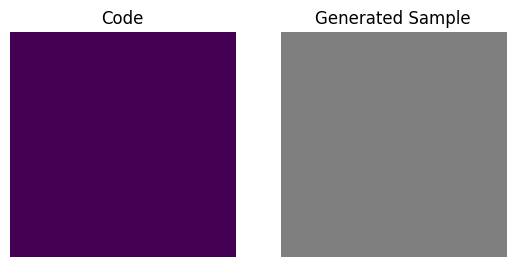

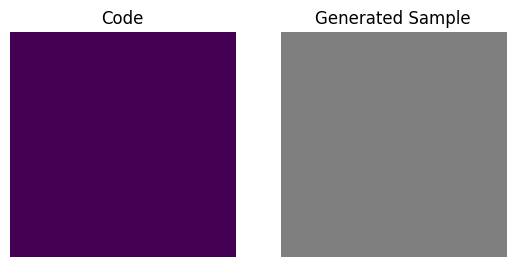

In [156]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()